In [1]:
from pathlib import Path

DRIVE_PATH = "/content/drive/MyDrive/UFF/Disciplinas/tratamento-incertezas"
train_file = Path(DRIVE_PATH, "train_new_features.csv")
test_file = Path(DRIVE_PATH, "test_new_features.csv")

In [2]:
%pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 7.1 MB/s eta 0:00:00


In [3]:
import pandas as pd
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import gc
from datetime import datetime
import matplotlib.pyplot as plt

train_path = train_file
test_path = test_file
nrows = 10_000_000

# Hiperparâmetros CatBoost com GPU
params = {
    "loss_function": "Logloss",
    "eval_metric": "TotalF1:average=Macro;use_weights=False",
    "depth": 6,
    "iterations": 5000,
    "random_seed": 42,
    "verbose": 100,
    "scale_pos_weight": 47.56,
    "task_type": "GPU",
    "devices": "0",
}
model = CatBoostClassifier(**params)

df = pd.read_csv(train_path)
df.head()

,tr_id,route_changed,date_index,rtt_mean,rtt_std,rtt_range,rtt_count,time_since_last,reply_ratio,probe_efficiency,pair_id
0,0,0,1,210.09,0.0,0.0,1,0.0,1.0,0.33,0
1,1,0,1,210.09,0.0,0.0,1,0.0,1.0,0.33,0
2,2,0,1,210.09,0.0,0.0,1,0.0,1.0,0.33,0
3,3,0,1,210.09,0.0,0.0,1,0.0,1.0,0.33,0
4,4,0,1,210.09,0.0,0.0,1,0.0,1.0,0.33,0


In [ ]:
print(f"\nProcessando ({len(df)} linhas)")

if "route_changed" not in df.columns:
    raise ValueError("Coluna 'route_changed' não encontrada no arquivo de treino!")

# shuffle nos dados
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Separar features e alvo
X = df.drop(columns=["route_changed", "tr_id"], errors="ignore")
y = df["route_changed"]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.10, random_state=42)
train_pool = Pool(X_train, label=y_train)
val_pool = Pool(X_val, label=y_val)

# Treinar
model.fit(train_pool, eval_set=val_pool, use_best_model=True)
eval_results = model.get_evals_result()

# Avaliar o modelo
preds = model.predict(X_val)
f1 = f1_score(y_val, preds, average="macro")
print(f"F1 Macro: {f1:.4f}")

# Limpar memória
del df, X, y, X_train, X_val, y_train, y_val, train_pool, val_pool
gc.collect()

# Salvar o modelo com timestamp
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
model_filename = f"{DRIVE_PATH}/catboost_final_{timestamp}.cbm"
model.save_model(model_filename)
print(f"Modelo salvo como '{model_filename}'")


Processando (10000000 linhas)
Learning rate set to 0.016867
0:	learn: 0.8622010	test: 0.8620320	best: 0.8620320 (0)	total: 118ms	remaining: 9m 50s
100:	learn: 0.8622010	test: 0.8620184	best: 0.8620320 (0)	total: 9.72s	remaining: 7m 51s
200:	learn: 0.8622010	test: 0.8620184	best: 0.8620320 (0)	total: 19.9s	remaining: 7m 54s
300:	learn: 0.8622010	test: 0.8620184	best: 0.8620320 (0)	total: 28.4s	remaining: 7m 23s
400:	learn: 0.8622010	test: 0.8620184	best: 0.8620320 (0)	total: 38s	remaining: 7m 16s
500:	learn: 0.8622055	test: 0.8620184	best: 0.8620320 (0)	total: 47.6s	remaining: 7m 7s
600:	learn: 0.8622221	test: 0.8620320	best: 0.8620320 (0)	total: 56.1s	remaining: 6m 50s
700:	learn: 0.8622304	test: 0.8620387	best: 0.8620387 (676)	total: 1m 5s	remaining: 6m 41s
800:	learn: 0.8622717	test: 0.8621063	best: 0.8621063 (799)	total: 1m 15s	remaining: 6m 33s
900:	learn: 0.8624004	test: 0.8621941	best: 0.8621941 (885)	total: 1m 24s	remaining: 6m 23s
1000:	learn: 0.8624004	test: 0.8622009	best: 0

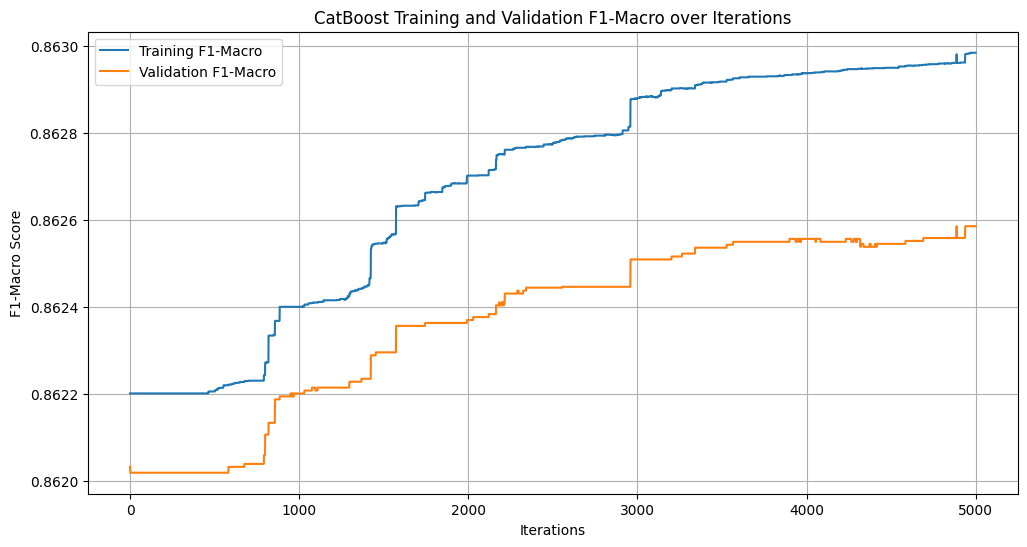

In [ ]:
# Plotar as métricas do histórico de avaliação
plt.figure(figsize=(12, 6))

plt.plot(eval_results['learn']['TotalF1:average=Macro;use_weights=false'],
         label='Training F1-Macro')
plt.plot(eval_results['validation']['TotalF1:average=Macro;use_weights=false'],
         label='Validation F1-Macro')

plt.xlabel('Iterations')
plt.ylabel('F1-Macro Score')
plt.title('CatBoost Training and Validation F1-Macro over Iterations')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
test = pd.read_csv(test_file)
test = test.sort_values(['tr_id']).reset_index(drop=True)
test.head()

,tr_id,date_index,rtt_mean,rtt_std,rtt_range,rtt_count,time_since_last,reply_ratio,probe_efficiency,pair_id
0,19965159,107,59.95,0.0,0.0,1,350460.0,1.0,0.33,42
1,19965160,107,59.95,0.0,0.0,1,0.0,1.0,0.33,42
2,19965161,107,59.95,0.0,0.0,1,0.0,1.0,0.33,42
3,19965162,107,59.95,0.0,0.0,1,0.0,1.0,0.33,42
4,19965163,107,59.95,0.0,0.0,1,0.0,1.0,0.33,42


In [ ]:
X_test = test.drop(columns=["tr_id"], errors="ignore")

preds_test = model.predict(X_test)

# Geração de arquivo de submissão
print("\nGerando predições para submissão...")
submission = pd.DataFrame({
    "id": test["tr_id"],
    "target": preds_test.astype(int)
})

submission_file = Path(DRIVE_PATH, f"submission_{timestamp}.csv")
submission.to_csv(submission_file, index=False)
print(f"Arquivo '{submission_file}' gerado com sucesso!")